In [13]:
import pandas as pd
import numpy as np
import zipfile
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
import xgboost as xgb
from sklearn.svm import SVC

In [14]:
with zipfile.ZipFile('D:\Paigeon\IMDB Dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('D:\Paigeon\Dataset')

In [15]:
movies = pd.read_csv('D:\Paigeon\Dataset\IMDB Dataset.csv')

In [16]:
movies.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [17]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


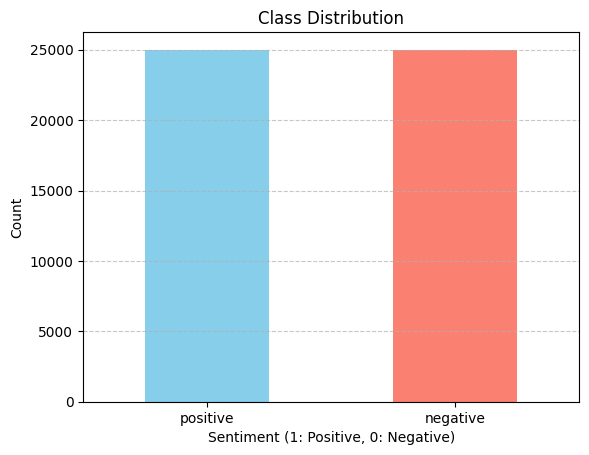

In [18]:
movies.sentiment.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Sentiment (1: Positive, 0: Negative)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### as there is no class imbalance and no data is missing we are moving to data cleaning

## Cleaning the text

In [19]:
# cleaning the text 
def clean_text(text):
    text=text.lower()
    text=re.sub(r'\d+','', text) # removing the diguits
    text = re.sub(r'<br\s*/?>', ' ', text)#removing the line breaks
    text=re.sub(r'<[^>]+>','',text)# removing extra html characters
    text=re.sub(r'\W', ' ', text) # rmoving special charcters
    text=re.sub(r'^http?:\/\/.*[\r\n]*','',text)# remving urls
    text= text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

In [20]:
movies['cleaned_review']=movies['review'].apply(clean_text)

In [21]:
movies.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming t...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...


In [22]:
#checking for nltk dictionary availability
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
def tokenize_text(text):
    return word_tokenize(text)

In [24]:
movies['tokenized_review']=movies['cleaned_review'].apply(tokenize_text)
movies

,review,sentiment,cleaned_review,tokenized_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming t...,"[a, wonderful, little, production, the, filmin..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...,"[basically, there, s, a, family, where, a, lit..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,"[petter, mattei, s, love, in, the, time, of, m..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,"[i, thought, this, movie, did, a, down, right,..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic di...,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,"[i, am, a, catholic, taught, in, parochial, el..."
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...,"[i, m, going, to, have, to, disagree, with, th..."


## Stop Words Removal

In [25]:
stopwords=set(stopwords.words('english'))

In [26]:
def remove_Stop_words(text):
    filtered_text=[word for word in text if word.lower() not in stopwords]
    #return ' '.join(filtered_text)
    return filtered_text

In [27]:
movies['tokenized_review']=movies['tokenized_review'].apply(remove_Stop_words)

In [28]:
movies

,review,sentiment,cleaned_review,tokenized_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, oz, epis..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming t...,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...,"[basically, family, little, boy, jake, thinks,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,"[petter, mattei, love, time, money, visually, ..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,"[thought, movie, right, good, job, creative, o..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic di...,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,"[catholic, taught, parochial, elementary, scho..."
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...,"[going, disagree, previous, comment, side, mal..."


## Lemmatization

In [29]:
def lemmatize_review(text):
    lemmatized_tokens=[lemmatizer.lemmatize(token) for token in text]
    return ' '.join(lemmatized_tokens)
    

In [30]:
# Initializing the lemmatizer
lemmatizer = WordNetLemmatizer()

In [31]:
movies['lemmatized_review'] = movies['tokenized_review'].apply(lemmatize_review)
movies

,review,sentiment,cleaned_review,tokenized_review,lemmatized_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, oz, epis...",one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming t...,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...,"[basically, family, little, boy, jake, thinks,...",basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,"[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,"[thought, movie, right, good, job, creative, o...",thought movie right good job creative original...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic di...,"[bad, plot, bad, dialogue, bad, acting, idioti...",bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,"[catholic, taught, parochial, elementary, scho...",catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...,"[going, disagree, previous, comment, side, mal...",going disagree previous comment side maltin on...


In [32]:
df=movies[['lemmatized_review','sentiment']]

In [33]:
def fix_contractions(text):
    fixed_text=[contractions.fix(word) for word in text.split()]
    return ' '.join(fixed_text)

In [34]:
movies['fixed_contractions']=movies['lemmatized_review'].apply(fix_contractions)

In [35]:
movies

,review,sentiment,cleaned_review,tokenized_review,lemmatized_review,fixed_contractions
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, oz, epis...",one reviewer mentioned watching oz episode hoo...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming t...,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...,"[basically, family, little, boy, jake, thinks,...",basically family little boy jake think zombie ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,"[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...,petter mattei love time money visually stunnin...
...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,"[thought, movie, right, good, job, creative, o...",thought movie right good job creative original...,thought movie right good job creative original...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic di...,"[bad, plot, bad, dialogue, bad, acting, idioti...",bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,"[catholic, taught, parochial, elementary, scho...",catholic taught parochial elementary school nu...,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...,"[going, disagree, previous, comment, side, mal...",going disagree previous comment side maltin on...,going disagree previous comment side maltin on...


In [36]:
def correct_spelling(text):
    # Create a TextBlob object and correct the spelling
    corrected_text = str(TextBlob(text).correct())
    return corrected_text

In [37]:
from symspellpy.symspellpy import SymSpell, Verbosity

# Initialize SymSpell object
max_edit_distance = 2
prefix_length = 7
sym_spell = SymSpell(max_dictionary_edit_distance=max_edit_distance, prefix_length=prefix_length)

# Load a frequency dictionary (you can download this or use a pre-built one)
# sym_spell.load_dictionary(dictionary_path, term_index, count_index)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)


# Function to correct spelling using SymSpell
def correct_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance)
    if suggestions:
        return suggestions[0].term  # Return the corrected word
    return text  # Return the original text if no corrections






In [38]:
movies['final_review']=movies['fixed_contractions'].apply(correct_spelling)

In [39]:
movies

,review,sentiment,cleaned_review,tokenized_review,lemmatized_review,fixed_contractions,final_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, oz, epis...",one reviewer mentioned watching oz episode hoo...,one reviewer mentioned watching oz episode hoo...,one reviewer mentioned watching of episode hoo...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming t...,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...,wonderful little production filming technique ...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...,"[basically, family, little, boy, jake, thinks,...",basically family little boy jake think zombie ...,basically family little boy jake think zombie ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,"[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...,petter mattei love time money visually stunnin...,petter matter love time money visually stunnin...
...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...,"[thought, movie, right, good, job, creative, o...",thought movie right good job creative original...,thought movie right good job creative original...,thought movie right good job creative original...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic di...,"[bad, plot, bad, dialogue, bad, acting, idioti...",bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...,"[catholic, taught, parochial, elementary, scho...",catholic taught parochial elementary school nu...,catholic taught parochial elementary school nu...,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,i m going to have to disagree with the previou...,"[going, disagree, previous, comment, side, mal...",going disagree previous comment side maltin on...,going disagree previous comment side maltin on...,going disagree previous comment side martin on...


In [40]:
df = movies[['final_review','sentiment']]

In [41]:
df

,final_review,sentiment
0,one reviewer mentioned watching of episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matter love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side martin on...,negative


In [42]:
sentiment_dict={'positive':1,'negative':0}

In [43]:
df.loc[:,'sentiment']=df['sentiment'].map(sentiment_dict)

In [44]:
df.tail()

,final_review,sentiment
49995,thought movie right good job creative original...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,going disagree previous comment side martin on...,0
49999,one expects star trek movie high art fan expec...,0


## Data Cleaning and pre-preocessing complete

--------------------------------------------------------------------------------------------------------------------------------------

## Implementing TF-IDF technique for Vectorization

In [45]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['final_review'])

In [46]:
y = df['sentiment'].astype(int)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


# 1. Multinomial NB

In [48]:
print("\nTraining MultinomialNB")
classifier = MultinomialNB()
classifier.fit(X_train, y_train)


Training MultinomialNB


MultinomialNB()

In [49]:
y_pred = classifier.predict(X_test)

In [50]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8621
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      4961
           1       0.86      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [52]:
#implementing Grid Search for Multinomial NB

param_grid = {
    'alpha': [0.1, 0.5, 1.0]  # Example for Naive Bayes
}

grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

In [53]:
y_best_pred=best_model.predict(X_test)

In [54]:
print("Accuracy:", accuracy_score(y_test, y_best_pred))

Accuracy: 0.8621


In [55]:
## using Bi-gram for other models 

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df['final_review'], y, test_size=0.2, random_state=42)


In [57]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## 2.RandomForest

In [58]:
print ("\n TRaining Random Forest")
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_tfidf, y_train)


 TRaining Random Forest


RandomForestClassifier(random_state=42)

In [59]:
y_pred = classifier.predict(X_test_tfidf)

In [60]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8617
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      4961
           1       0.87      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## 3. XGBOOST

In [61]:
print("Training XGBoost...")
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train_tfidf, y_train)

Training XGBoost...


d:\python\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [62]:
y_pred_xgb = xgboost_model.predict(X_test_tfidf)

In [63]:
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8565
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.85      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## 4. Logistic Regression

In [64]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

LogisticRegression()

In [65]:
y_pred=lr.predict(X_test_tfidf)

In [66]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8936
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## 5. SVM

In [67]:
print("\nTraining SVM...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)


Training SVM...


SVC(kernel='linear', random_state=42)

In [68]:
y_pred_svm = svm_model.predict(X_test_tfidf)

In [69]:
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.909
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      4961
           1       0.90      0.92      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



---------------------------------------------------

## Implementing Word2vec library for vectorization

In [70]:
word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, sg=0)  # CBOW model

In [71]:
def document_vector(doc):
    # Remove out-of-vocabulary words
    words = [word for word in doc if word in word2vec_model.wv.index_to_key]
    return np.mean(word2vec_model.wv[words], axis=0) if words else np.zeros(word2vec_model.vector_size)

In [72]:
X_train_vec = np.array([document_vector(doc) for doc in X_train])
X_test_vec = np.array([document_vector(doc) for doc in X_test])

## 1. Logistic Regression

In [73]:
classifier = LogisticRegression()
classifier.fit(X_train_vec, y_train)

LogisticRegression()

In [74]:
y_pred = classifier.predict(X_test_vec)

In [75]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5875
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58      4961
           1       0.59      0.61      0.60      5039

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



## 2. Gaussian NB

In [76]:
print ("Training GaussianNB")
gaussian_nb_classifier = GaussianNB()
gaussian_nb_classifier.fit(X_train_vec, y_train)



Training GaussianNB


GaussianNB()

In [77]:
# Predictions
y_pred_nb = gaussian_nb_classifier.predict(X_test_vec)



In [78]:
# Evaluation
print("Accuracy (Naive Bayes):", accuracy_score(y_test, y_pred_nb))
print("Classification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb))

Accuracy (Naive Bayes): 0.5641
Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.56      0.60      0.58      4961
           1       0.57      0.53      0.55      5039

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



## 3. SVM

In [79]:
print("\nTraining SVM...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_vec, y_train)


Training SVM...


SVC(kernel='linear', random_state=42)

In [80]:
y_pred_svm = svm_model.predict(X_test_vec)

In [81]:
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.5908
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.56      0.58      4961
           1       0.59      0.62      0.61      5039

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



## 4. XGBoost

In [82]:
print("Training XGBoost...")
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train_vec, y_train)

Training XGBoost...


d:\python\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [83]:
y_pred_xgb = xgboost_model.predict(X_test_vec)

In [84]:
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.5868
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.59      0.59      4961
           1       0.59      0.58      0.59      5039

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



## 5. Random Forest

In [85]:
print("Training Random Forest")
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_vec, y_train)

Training Random Forest


RandomForestClassifier(random_state=42)

In [86]:
y_pred = classifier.predict(X_test_vec)

In [87]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5943
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60      4961
           1       0.60      0.59      0.59      5039

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000

